# Detect AI vs Human generated images
In this notebook, I aim to build a convnet architecture for detecting real images from fake ones.

In [11]:
# All imports needed for this classification project
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Download latest version
data_path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", data_path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [3]:
# Csv files with paths to the images
train = pd.read_csv(data_path+"/"+"train.csv", index_col=0)
test = pd.read_csv(data_path+"/"+"test.csv")

In [4]:
print(train.head())

                                         file_name  label
0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1


In [5]:
def create_image_fullpath(file_path, labels=None):
    """
    Creates an array with full path to the images.
    Labels array created where appropriate.
    """
    full_path = [data_path +"/"+ image_path for image_path in file_path]
    full_path = np.array(full_path)
    if labels is not None:
        labels = np.array(labels)
        return full_path, labels
    else:
        return full_path

In [6]:
# Creates full paths to images
train_full_path, labels = create_image_fullpath(train["file_name"], train["label"])
test_full_path = create_image_fullpath(test["id"])

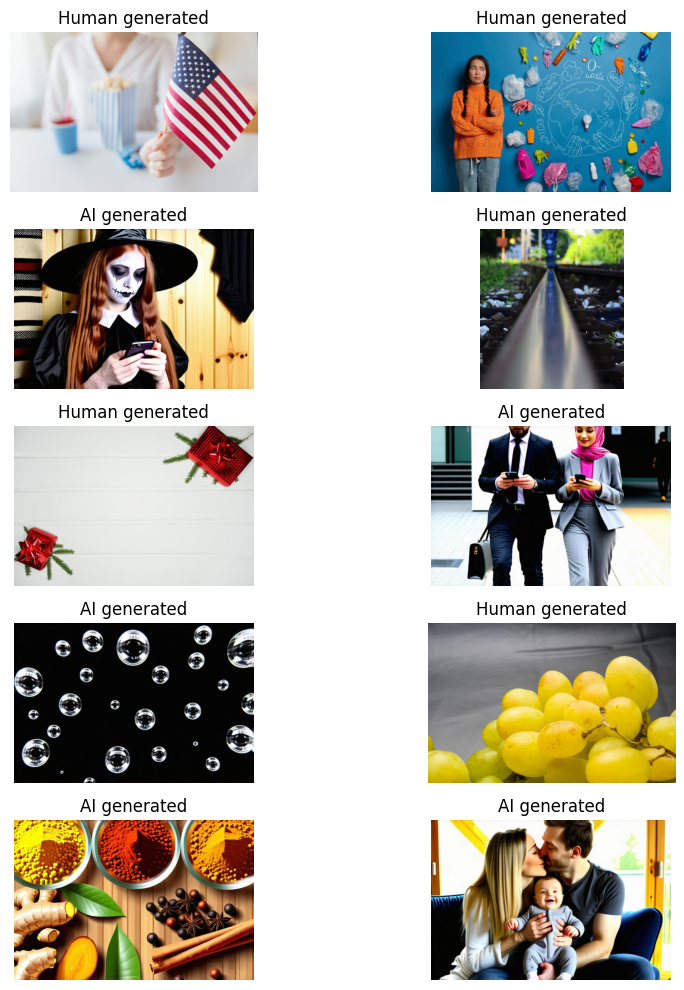

In [10]:
# Visualize the the first ten images. 
fig, ax = plt.subplots(5, 2, figsize=(10,10))

index = -1
for i in range(5):
    for j in range(2):
        im = plt.imread(train_full_path[index])
        ax[i][j].imshow(im)
        ax[i][j].axis("off")
        
        if labels[index] == 0:
            ax[i][j].set_title("Human generated")
        else:
            ax[i][j].set_title("AI generated")
            
        index -= 1

        
            
fig.tight_layout()
        


Based on the above visualizations, it's evidented the data isn't shuffled and image sizes are different.

In [9]:
# Shuffle train data
indices = np.random.permutation(len(train_full_path))
train_full_path, labels = train_full_path[indices], labels[indices]

In [ ]:
# Split train into train, test, and validation data

# Step 1: Split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(train_full_path, 
                                                    labels, 
                                                    test_size=0.3, 
                                                    random_state=44)
# Step 2: Split temp into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, 
                                                y_temp, 
                                                test_size=0.5, 
                                                random_state=44)


In [ ]:
def load_preprocess_image(X, y=None):
    image = tf.io.read_file(train_full_path[10])
    image = tf.image.decode_jpeg(image)/255
    image_resized = tf.image.resize(image, [224, 224])
    